In [ ]:
#| default_exp pipelines

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# Imports and setup

### Unconditional imports

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp

print(timestamp(), "Beginning to load dependencies")

2025-11-19 16:48:33.552678: Beginning to load dependencies


In [ ]:
#|export
from pathlib import Path
from shutil import rmtree

import numpy as np
import polars as pl
from fastcore.all import in_ipython

from clip_plot.configuration import Cfg, ClusterSpec, ImageLoaderOptions, UmapSpec, ViewerOptions
from clip_plot.embeddings import get_embeddings
from clip_plot.from_tables import cat_tables, table_to_meta
from clip_plot.images import ImageFactory, write_viewer_images
from clip_plot.metadata import get_manifest, write_metadata
from clip_plot.web_config import copy_web_assets, get_clip_plot_root



## Entry

`project_images` will kick off all the main functions for the module

In [ ]:
#| export

def project_images_pipeline(output_dir: Path,
                            plot_id: str,
                            model: str,
                            viewer_opts: ViewerOptions,
                            umap_spec: UmapSpec,
                            cluster_spec: ClusterSpec,
                            image_opts: ImageLoaderOptions,
                            images: list[Path] | None = None,
                            tables: list[Path] | None = None,
                            metadata: list[Path] | None = None,
                            image_path_col: str = "image_path",
                            vectors_col: str = "hidden_vectors",
                            x_col: str | None = None,
                            y_col: str | None = None,
        ):
        """Convert a folder of images into a clip-plot visualization"""

        # TODO: use a dataframe instead
        meta_names:list[str] = []
        meta_vals: list[dict] | None = None
        if tables and images:
                raise ValueError("Provide either tables or images parameter, not both.")
        if not tables and not images:
                raise ValueError("No images found from either tables or images input.")
        if tables and not images:
                print(timestamp(), "Loading tables")
                table: pl.DataFrame | None = cat_tables(tables)
                images: list[Path] = [Path(p) for p in table[image_path_col].to_numpy()]
                print(timestamp(), "Loading embeddings from disk")
                hidden_vectors: np.ndarray | None = table[vectors_col].to_numpy()
                meta_names, meta_vals= table_to_meta(table)
        elif not tables and images:
                hidden_vectors = get_embeddings(images, model_name=model)

        data_dir = output_dir / "data"
        imageEngine = ImageFactory(images, data_dir, metadata,
                                            **image_opts.model_dump())

        # TODO: simplify the mad tables/metadata possibilities
        if meta_vals:
                imageEngine.meta_headers = meta_names
                imageEngine.metadata = meta_vals

        print(f"Config to project images: {str(image_opts.model_dump())}")

        np.random.seed(image_opts.seed)
        print(timestamp(), "Starting image processing pipeline.")

        copy_web_assets(output_dir=output_dir,
                        tagline=viewer_opts.tagline, logo=viewer_opts.logo)

        atlas_positions = write_viewer_images(imageEngine, plot_id,
                        data_dir=data_dir, thumb_size=image_opts.thumbnail_size,
                        cell_size=image_opts.atlas_cell_size, atlas_size=image_opts.atlas_size)
        write_metadata(imageEngine)

        if imageEngine.metadata:
                has_metadata=True
        else:
                has_metadata=False

        get_manifest(imageEngine, atlas_positions, hidden_vectors,
                     plot_id=plot_id, output_dir=output_dir,
                     umap_spec=umap_spec, cluster_spec=cluster_spec,
                     x_col=x_col, y_col=y_col,
                     has_metadata=has_metadata
        )
        # write_images(imageEngine)
        print(timestamp(), "Done!")

### Embed images without building visualization

Outputs a table linking the embedding files to the images

Test with bash command:
```
clipplot_embed_images --images "tests/smithsonian_butterflies_10/jpgs/*.jpg" --output_dir "tests/smithsonian_butterflies_10/DELETEME_embed_only" --metadata "tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
```

In [ ]:
#| export

def embed_images_pipeline(images: list[Path],
                     model: str,
                     metadata: list[Path] | None,
                     output_dir: Path,
                     table_format: str,
                     table_id: str,
                ):
                """Embed a folder of images, save embeddings as .npy file to disk"""
                output_dir = Path(output_dir)
                data_dir = output_dir / "data"
                table_dir = output_dir / "data" / "tables"

                imageEngine = ImageFactory(image_paths=images, data_dir=data_dir, metadata_paths=metadata)

                embeddings = get_embeddings(image_paths=images, model_name=model)
                df = pl.DataFrame({"image_path": images,
                                   "image_filename": imageEngine.filenames,
                                   "hidden_vectors": embeddings,
                })

                if len(imageEngine.metadata) > 0:
                        df_meta = pl.DataFrame(imageEngine.metadata)
                        df_meta = df_meta.rename({"filename": "image_filename"})
                        # drop "image_path" column if df_meta has it
                        if "image_path" in df_meta.columns:
                                df_meta = df_meta.drop("image_path")

                        df = df.join(df_meta.unique(subset=["image_filename"]), on="image_filename",
                                              how="left")

                df = df.with_columns(pl.col("image_path").map_elements(
                                     lambda x: x.as_posix(),  return_dtype=pl.Utf8))

                ## standardize sort order of table
                # put standard columns in a sensible order if they exist in df
                standard_cols: set[str] = {"image_path", "image_filename", "hidden_vectors",
                                                   "category", "tags", "x", "y"}
                cols_in_order = list(standard_cols & set(df.columns))
                # append non-standard columns, sorted alphabetically
                non_standard_cols: list[str] = sorted(set(df.columns) - standard_cols)
                cols_sorted = cols_in_order + non_standard_cols
                df = df.with_columns(cols_sorted)

                table_dir.mkdir(parents=True, exist_ok=True)
                if table_format == "csv":
                        df.write_csv(table_dir / f"EmbedImages__{table_id}.csv")
                else:
                        df.write_parquet(table_dir / f"EmbedImages__{table_id}.parquet")

In [ ]:
#| hide

def test_butterfly():
    copy_root_dir = get_clip_plot_root()
    tests_dir = copy_root_dir.parents[0] / "tests"

    test_images = tests_dir / "smithsonian_butterflies_10/jpgs/*.jpg"
    test_output_dir = tests_dir / "smithsonian_butterflies_10/output_test_temp"
    meta = tests_dir / "smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_output_dir).exists():
        rmtree(test_output_dir)

    # local model if it exists
    model = "../models/timm__vit_pe_core_tiny_patch16_384.fb"
    if not Path(model).exists():
        model = "timm/vit_pe_core_tiny_patch16_384.fb"

    cfg = Cfg(paths={"images": test_images},
                   model=model,
                   cluster_spec={"min_cluster_size": 3},
                   )

    project_images_pipeline(images=cfg.paths.images,
                   output_dir=test_output_dir,
                   metadata=[meta],
                   plot_id="test_diff",
                   model=cfg.model,
                   viewer_opts = cfg.view_opts,
                   umap_spec = cfg.umap_spec,
                   cluster_spec = cfg.cluster_spec,
                   image_opts = cfg.image_opts,
                   )

    return

Device for inference: cuda


Device set to use cuda


2025-11-19 16:48:46.189570: Creating embeddings using timm/vit_pe_core_tiny_patch16_384.fb


  0%|          | 0/12 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


2025-11-19 16:48:47.426742: Done creating embeddings.
2025-11-19 16:48:47.428792: First three paths: /home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/30aeb051d-ee0d-4c5b-8a85-a8da7baef5fd.jpg
/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/9fea3150-a3d4-11ed-aeea-e36f1256f233.jpg
/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/329a4c094-8536-4396-be70-3d9b5d0744d9.jpg
2025-11-19 16:48:47.428883: Validating input images


  0%|          | 0/12 [00:00<?, ?it/s]

Config to project images: {'seed': 42, 'shuffle': False, 'atlas_row_height': 128, 'thumbnail_size': 128, 'atlas_size': 4096, 'max_images': None}
2025-11-19 16:48:47.713349: Starting image processing pipeline.
2025-11-19 16:48:47.755962: Creating image files for viewer
2025-11-19 16:48:47.756028: Copying thumbnails to output directory


  0%|          | 0/12 [00:00<?, ?it/s]

2025-11-19 16:48:48.032173: Copying originals to output directory


  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Number of atlases generated: 1
2025-11-19 16:48:48.868458: Importing UMAP libraries
2025-11-19 16:48:53.660752: UMAP variants to compute:
[{'filename': 'umap-n_neighbors_15-min_dist_0.1',
  'min_dist': 0.1,
  'n_neighbors': 15,
  'out_path': Path('/home/willsa/git/clip-plot/tests/smithsonian_butterflies_10/output_test_temp/data/layouts/test_diff__umap-n_neighbors_15-min_dist_0.1.json')}]
2025-11-19 16:48:53.661255: Creating single UMAP layout


/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2025-11-19 16:49:02.313466: Creating umap-n_neighbors_15-min_dist_0.1 pointgrid
2025-11-19 16:49:02.330766: Creating grid layout
2025-11-19 16:49:02.331781: Creating rasterfairy layout


/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:267: RuntimeWarning: invalid value encountered in divide
  density_top /= np.sum(density_top)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:273: RuntimeWarning: invalid value encountered in divide
  density_right /= np.sum(density_right)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:279: RuntimeWarning: invalid value encountered in divide
  density_bottom /= np.sum(density_bottom)
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:285: RuntimeWarning: invalid value encountered in divide
  density_left /= np.sum(density_left)


2025-11-19 16:49:02.891250: Coonswarp rectification could not be performed data must be finite, check for nan or inf values
applying hungarian assignment for 12 indices
2025-11-19 16:49:02.893338: Creating categorical layout
2025-11-19 16:49:03.409167: Clustering data with HDBSCAN
2025-11-19 16:49:03.420175: Found 0 hotspots
2025-11-19 16:49:03.422161: Done!


/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/willsa/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


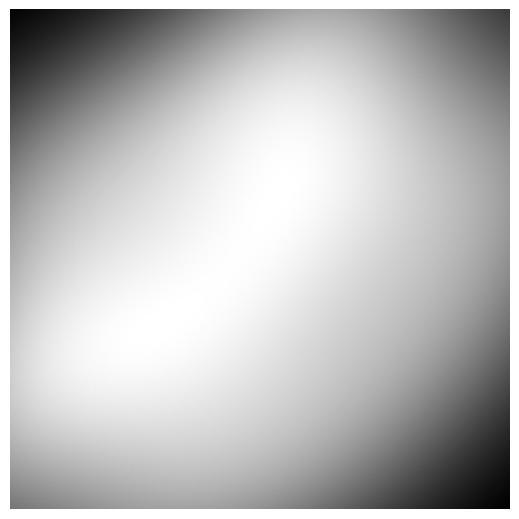

In [ ]:
#| hide

if __name__ == "__main__" and in_ipython():
    test_butterfly()

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()